# DAQ（v5）

- ``20240125_single_daq.ipynb``を改良したバージョンです。

# ディスクの残り容量を確認する

- ``df -H``のセルを実行し、ディスク（microSDカード）の使用状況を確認できます
  - ``/dev/root`` の情報を確認してください
  - ``Use%``が80%を超えている場合は、測定データを削除することを考えたほうがいいかもしれません

In [1]:
!df -H

Filesystem      Size  Used Avail Use% Mounted on
/dev/root       7.1G  5.6G  1.1G  84% /
tmpfs           242M     0  242M   0% /dev/shm
tmpfs            97M  4.2M   93M   5% /run
tmpfs           5.3M     0  5.3M   0% /run/lock
none            5.3M  8.2k  5.3M   1% /var/log
/dev/mmcblk0p1  508M  323M  185M  64% /boot


- ``du -h -d 1``を実行し、現在のディレクトリの容量を確認できます
  - 容量が大きなファイルを優先的に削除すると、ディスク節約に効果的です

In [2]:
!du -h -d 1 .

23M	./data_v1
107M	./data
236K	./.ipynb_checkpoints
88M	./data_v2
283M	./data_v3
500M	.


# ローカル時刻を確認する

- RedPitayaはRTC（リアルタイムクロック）を持たないので、電源をOFFにした時点で、ローカル時刻が停止します。
- 測定を再開したときは、現在の時刻とローカル時刻がずれてないか確認してください。
- 時刻がずれている場合は、次のセルの時刻を現在時刻に修正して、コメントを外して実行してください
  - 時刻を合わせたあとはまたコメントアウトしてください

In [3]:
#!date -s "2024-03-22 16:11:00+09:00"

In [4]:
!date +%Y-%m-%dT%H:%M:%S

2024-03-25T22:21:19


# モジュールをインポートする

- データ取得に必要なPythonモジュールをインストールします
- Pythonノートブックのセッション開始時に、1回だけ実行してください
  - セッションを再起動（リスタート）したときは、再び実行してください

In [5]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import rp
from dataclasses import dataclass

print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"RedPitaya: {rp.rp_GetVersion()}")

print("Initialized RedPitaya")
rp.rp_Init()

NumPy: 1.21.5
Pandas: 1.3.5
RedPitaya: 2.00-30 (73ff4bc8f)
Initialized RedPitaya


0

# RedPitayaの初期化

- RedPitayaを初期化して測定の準備を開始します
- 関係ありそうなソースファイル
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/python/rp_overlay.py
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/src/rp.c
  - https://github.com/RedPitaya/RedPitaya/blob/master/rp-api/api/src/acq_handler.c

# 測定に必要はパラメーターを設定する

- デシメーション：データのサンプリング率
- トリガーレベル：トリガーの電圧値と信号の向き
- トリガーの遅延：
- バッファーサイズ（サンプリング数）

In [33]:
@dataclass
class UserSettings:
    channels = [rp.RP_CH_1, rp.RP_CH_2]
    triggers = {rp.RP_T_CH_1: 0.35, rp.RP_T_CH_2: 0.35}
    trigger_source: int = rp.RP_TRIG_SRC_CHA_PE
    trigger_delay: int = 0
    decimation: int = rp.RP_DEC_1
    buffers: int = 16384
    deltaT: int = 8  # ns/sample
    version: int = 5

    def __post_init__(self):
        self.update()

    def update(self):
        """インスタンスした時に、メンバー変数を追加する

        追加するメンバー変数
        - name: チャンネル名（channel_id + 1）
        - mv: トリガーレベルをmVに変換
        - fname_prefix: ファイル名のプリフィックス
        """
        self.nch = len(self.channels)
        prefix = f"cw_data_v{self.version}"
        if self.trigger_source == rp.RP_TRIG_SRC_CHA_PE:
            trigger_channel = "ch1"
            trigger_level = f"{int(self.triggers[rp.RP_T_CH_1] * 1000)}mV"
            mv = f"trg{trigger_level}mV"
            prefix = f"{prefix}_{trigger_channel}_{trigger_level}"
        elif self.trigger_source == rp.RP_TRIG_SRC_CHB_PE:
            trigger_channel = "ch2"
            trigger_level = f"{int(self.triggers[rp.RP_T_CH_2] * 1000)}mV"
            prefix = f"{prefix}_{trigger_channel}_{trigger_level}"
        else:
            self.fname_prefix = prefix
        self.fname_prefix = prefix

    def show(self):
        """設定値を表示する"""
        print("# User Settings")
        print(f"Number of channels: {self.nch}")
        for ich, iv in self.triggers.items():
            print(f"Set trigger channel: {ich} | level: {iv}")
        print(f"Set trigger source: {self.trigger_source}")
        print(f"Set trigger delay: {self.trigger_delay}")
        print(f"Set sampling decimation: {self.decimation}")
        print(f"Set sampling buffer size: {self.buffers}")
        print(f"Set DAQ version: {self.version}")
        print(f"Set filename prefix: {self.fname_prefix}")

In [7]:
c = UserSettings()

## トリガーチャンネル
c.trigger_channel = rp.RP_T_CH_1  # 0
# c.trigger_channel = rp.RP_T_CH_2  # 1

## トリガーソース
## CHA|CHB : Ch1|Ch2に該当する
## PE : PositiveEdge（立ち上がり）でトリガー
# c.trigger_source = rp.RP_TRIG_SRC_CHA_PE  # 2
# c.trigger_source = rp.RP_TRIG_SRC_CHB_PE  # 4

## トリガーレベル
## 電圧[V]で設定する
# c.trigger_level = 0.9 # 900mV

## トリガー遅延（サンプル点の数）
## 正の数：トリガー点が左に移動する
## 負の数：トリガー点が右に移動する
# c.trigger_delay = 7500

## デシメーション
## サンプリング数を間引く度合い
# c.decimation = rp.RP_DEC_1

## バッファーサイズ（サンプリング数）
## 最大値：16384
# c.samples = 1500

# 設定した値を確認する
c.update()
c.show()

# User Settings
Number of channels: 2
Set trigger channel: 0 | level: 0.5
Set trigger channel: 1 | level: 0.5
Set trigger source: 2
Set trigger delay: 0
Set sampling decimation: 1
Set sampling buffer size: 16384
Set DAQ version: 5
Set filename prefix: cw_data_v5_ch1_500mV


# DAQをセットアップする

In [8]:
def setup_daq(config: UserSettings):
    """DAQをセットアップする"""
    # APIコマンドを初期化する
    if rp.rp_IsApiInit() == 0:
        rp.rp_Init()
        print("# Initialized API commands")

    # DAQをリセットする
    print("# Reset DAQ")
    rp.rp_AcqReset()

    # パラメーターを設定する
    print("# Set DAQ paramaters")
    _triggers = config.triggers
    _delay = config.trigger_delay
    _decimation = config.decimation

    for ich, iv in _triggers.items():
        rp.rp_AcqSetTriggerLevel(ich, iv)
        _check, _value = rp.rp_AcqGetTriggerLevel(ich)
        print(f"Set trigger: {ich} | level: {iv} ==> {_value}")

    rp.rp_AcqSetTriggerDelay(_delay)
    _check, _value = rp.rp_AcqGetTriggerDelay()
    print(f"Set trigger delay: {_delay} ==> {_value}")

    rp.rp_AcqSetDecimation(_decimation)
    _check, _value = rp.rp_AcqGetDecimation()
    print(f"Set decimation: {_decimation} ==> {_value}")

    time.sleep(0.1)

    print("# Start DAQ")
    rp.rp_AcqStart()
    time.sleep(0.1)

    _source = config.trigger_source
    rp.rp_AcqSetTriggerSrc(_source)
    _check, _value = rp.rp_AcqGetTriggerSrc()
    print(f"Set trigger source: {_source} ==> {_value}")
    time.sleep(0.1)

    return

In [9]:
# c = UserSettings()
# setup_daq(c)

# DAQのステータスを確認する

- 好きなところで確認できるように`check_daq_status``を作成しました

In [10]:
def check_daq_status(config: UserSettings):
    """DAQの設定を確認する
    Args:
        config(UserSettings): ユーザー設定
    Returns:
        status(dict): 確認したステータスをまとめた辞書型データ
    """
    print("# Check DAQ Status")
    status = {}

    triggers = config.triggers
    for ich in triggers.keys():
        trigger_level = rp.rp_AcqGetTriggerLevel(ich)[1]
        print(f"Get trigger channel: {ich}")
        print(f"Get trigger level: {trigger_level}")
        status[f"trigger_ch{ich}"] = trigger_level

    trigger_delay = rp.rp_AcqGetTriggerDelay()[1]
    print(f"Get trigger delay: {trigger_delay}")
    status["trigger_delay"] = trigger_delay

    decimation = rp.rp_AcqGetDecimation()[1]
    print(f"Get sampling decimation: {decimation}")
    status["decimation"] = decimation

    trigger_source = rp.rp_AcqGetTriggerSrc()[1]
    print(f"Get trigger source: {trigger_source}")
    status["trigger_source"] = trigger_source

    return status

In [11]:
# c = UserSettings()
# c.trigger_level = 0.8
# c.update()
# setup_daq(c)
# check_daq_status(c)

# トリガーがかかるまで待つ

In [12]:
def single_event_trigger() -> int:
    """1イベントのトリガーを待つ"""
    # トリガーを待つ
    print("Waiting for a trigger...")
    print(f"Trigger state: {rp.rp_AcqGetTriggerState()}")
    print(f"Fill state: {rp.rp_AcqGetBufferFillState()}")
    counter = 0

    while 1:
        trigger_state = rp.rp_AcqGetTriggerState()[1]
        counter = counter + 1
        if counter % 1000000 == 0:
            print(f"Loop: {counter}")
        if trigger_state == rp.RP_TRIG_STATE_TRIGGERED:
            break

    print("Triggered!")
    print(f"Trigger state: {rp.rp_AcqGetTriggerState()}")
    print(f"Fill state: {rp.rp_AcqGetBufferFillState()}")

    # データがあるか確認する
    while 1:
        if rp.rp_AcqGetBufferFillState()[1]:
            break

    print("Got Data")
    return counter

In [13]:
# config = UserSettings()
# setup_daq(c)
# single_event_trigger()

# 波形データを読み出す

In [14]:
def single_event_readout(config: UserSettings) -> pd.DataFrame:
    """波形データをデータフレームに変換する

    # チャンネル番号に応じた内部バッファー（osc_cha, osc_chb, osc_chc, osc_chd）
    # チャンネル番号に応じたバッファーを読み出せる（osc_GetDataBufferChA(), ...）
    # チャンネル番号を指定してバッファーを読み出す（getRawBuffer(チャンネル))
    # ADC値を読み出す（rp_AcqGetOldestDataRaw(チャンネル番号, サイズ, バッファー)）
    # 電圧に変換した値を読み出す（rp_AcqGetOldestDataV(チャンネル番号, サイズ, バッファー)）
    """

    print("# Convert waveforms into pd.DataFrame")

    # 内部変数
    _buffers = config.buffers
    _channels = config.channels
    _version = config.version
    _deltaT = config.deltaT

    # 波形データをデータフレームに変換する
    waveforms = {}

    for ich in _channels:
        # RAW（ADC値）
        ibuff = rp.i16Buffer(_buffers)
        res = rp.rp_AcqGetOldestDataRaw(ich, _buffers, ibuff.cast())[1]

        # Volts（ADC値を電圧（V）に変換した値）
        fbuff = rp.fBuffer(_buffers)
        res = rp.rp_AcqGetOldestDataV(ich, _buffers, fbuff)[1]

        # データを保存する配列を作成する
        data_raw = np.zeros(_buffers, dtype=int)
        data_volts = np.zeros(_buffers, dtype=float)

        # データをコピーする
        for i in range(0, _buffers, 1):
            data_raw[i] = ibuff[i]
            data_volts[i] = fbuff[i]

        # データを代入する
        key1 = f"raw{ich+1}"
        key2 = f"v{ich+1}"
        waveforms[key1] = data_raw
        waveforms[key2] = data_volts

    data = pd.DataFrame(waveforms)
    data["x"] = data.index
    data["time"] = data.index * _deltaT
    data["deltaT"] = data["time"].diff()
    data["totalT"] = data["deltaT"].cumsum()

    return data

In [15]:
# c = UserSettings()
# setup_daq(c)
# single_event_trigger()
# data = single_event_readout(c)
# data

# スレッショルドを再計算する

- データの先頭から"100:200"あたりを使ってベースラインを計算する
- ベースラインの平均値と標準偏差を使って、信号の閾値を計算する

In [16]:
def get_threshold(
    data: pd.DataFrame, name: str, width: float = 3.0
) -> tuple[float, float, float]:
    """信号の閾値を計算する
    Args:
        data(pd.DataFrame): 波形データ
        name(str): 計算したいカラム名
        width(float): 閾値の幅
    Returns:
        threshold(float)
    """
    copied = data.copy()
    mean = copied[name].mean()
    std = copied[name].std()
    threshold = mean + width * std
    return mean, std, threshold

In [17]:
# print(get_threshold(data.iloc[100:200], name="v1"))
# print(get_threshold(data.iloc[100:200], name="v2"))

In [18]:
def discriminator(data: pd.DataFrame, name: str, start: int = 100, end: int = 200):
    copied = data.copy()

    # オフセット補正
    mean, std, threshold = get_threshold(copied.iloc[start:end], name)
    copied["fixed"] = copied[name] - mean

    # スレショルド補正
    copied["valid"] = 0.0
    isT = copied["fixed"] > threshold
    copied.loc[isT, "valid"] = copied["fixed"]

    return copied["fixed"], copied["valid"]

In [19]:
# data["v1_fixed"], data["v1_valid"] = discriminator(data, name="v1")
# data["v2_fixed"], data["v2_valid"] = discriminator(data, name="v2")
# data

In [20]:
def get_deltaQ(
    data: pd.DataFrame,
    name: str,
    unitV: float = 1.0,
    unitT: float = 1e-6,
    ohmR: float = 50.0,
):
    """サンプルあたりの電荷を計算する
    Args:
        data(pd.DataFrame): 波形データ（スレッショルド適応済み）
        name(str): 計算に使うカラム名（[v1_valid|v2_valid]）
        unitV(float): 測定した電圧の単位（デフォルトは V）
        unitT(float): 測定した時間の単位（デフォルトは 1e-6 s）
        ohmR(float): 測定したときの抵抗値（デフォルトは 50.0 Ohm）
    """
    copied = data.copy()
    unitQ = unitV * unitT / ohmR
    deltaQ = copied[name] * data["deltaT"] * unitQ
    return deltaQ

In [21]:
def add_deltaQ(data: pd.DataFrame):
    """電荷を計算したカラムを追加する"""
    copied = data.copy()

    # Ch1の計算
    copied["v1_fixed"], copied["v1_valid"] = discriminator(data, name="v1")
    copied["q1"] = get_deltaQ(copied, name="v1_valid")

    # Ch2の計算
    copied["v2_fixed"], copied["v2_valid"] = discriminator(data, name="v2")
    copied["q2"] = get_deltaQ(copied, name="v2_valid")

    return copied

# TOFを計算する

- ベースラインとスレッショルド補正した波形データを使う（``v1_valid`` | ``v2_valid``）
- この2つのデータを使って相関関数を計算する

In [22]:
def get_tof(data: pd.DataFrame):
    pass

# イベントサマリーを確認する

In [23]:
def single_event_summary(config: UserSettings, data: pd.DataFrame):
    """波形データの最大値を確認する
    Args:
        config(UserSettings): パラメーター
        data(pd.DataFrame): 波形データ（補正済み）
    """

    print("# Check waveforms")

    # 電荷を計算する
    q1 = data["q1"].sum()
    q2 = data["q2"].sum()

    # 波高の最大値を取得する
    max1 = data["v1_valid"].max()
    max2 = data["v2_valid"].max()

    # 波高が最大値のインデックス（=X軸）を取得する
    x1 = data["v1_valid"].idxmax()
    x2 = data["v2_valid"].idxmax()

    # データフレームを表示する
    # display(data[x1-10:x1+10])
    print(f"v1 (max) = {max1} V")
    print(f"v2 (max) = {max2} V")

    summary = {
        "x1": x1,
        "max1": max1,
        "q1": q1,
        "x2": x2,
        "max2": max2,
        "q2": q2,
    }
    return summary

In [24]:
# c = UserSettings()
# setup_daq(c)
# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# single_event_summary(c, data)

# 波形をグラフにする

In [25]:
def single_event_draw(config: UserSettings, data: pd.DataFrame):
    """波形データを描画する"""

    print("# Draw waveforms")
    n1 = data["v1"].idxmax()
    n2 = data["v2"].idxmax()

    # データをプロットする
    fig, axs = plt.subplots(2, 3, figsize=(10, 5), layout="constrained")
    title = config.fname_prefix
    fig.suptitle(title)
    axs = axs.ravel()

    width = 200
    data[n1 - width : n1 + width].plot.scatter(x="x", y="raw1", ax=axs[0])
    data[n1 - width : n1 + width].plot.scatter(x="time", y="v1", ax=axs[1])
    data[n1 - width : n1 + width].plot.scatter(x="time", y="q1", ax=axs[2], c="green")

    data[n2 - width : n2 + width].plot.scatter(x="x", y="raw2", ax=axs[3], c="red")
    data[n2 - width : n2 + width].plot.scatter(x="time", y="v2", ax=axs[4], c="red")
    data[n2 - width : n2 + width].plot.scatter(x="time", y="q2", ax=axs[5], c="green")

    return fig

In [26]:
# c = UserSettings()
# setup_daq(c)
# count = single_event_trigger()
# data = single_event_readout(c)
# checked = single_event_check(c, data)
# single_event_draw(c, data)

# データを保存する

In [27]:
def single_event_save(
    config: UserSettings, data: pd.DataFrame, figure: matplotlib.figure.Figure
):
    """データフレームを保存する
    Args:
        config(UserSettings): ユーザー設定
        data(pd.DataFrame): 波形データ（いろいろ計算済み）
        figure(Figure): 波形データの図
    Returns:
        saved(dict): 保存したデータのサマリー
    """

    print("# Save data")
    version = config.version
    prefix = config.fname_prefix
    unixtime = time.time()
    now = datetime.datetime.now()
    dt = now.strftime("%Y%m%d_%H%M%S")

    data["timestamp"] = now
    data["unixtime"] = unixtime
    data["version"] = version

    saved = {
        "timestamp": now,
        "version": version,
    }

    fname = f"data/{prefix}_{dt}.csv"
    data.to_csv(fname, index=False)
    print(f"Saved to {fname}")
    saved["csv"] = fname

    fname = f"data/{prefix}_{dt}.png"
    figure.savefig(fname)
    print(f"Saved to {fname}")
    saved["png"] = fname

    return saved

In [ ]:
# c = UserSettings()
# setup_daq(c)
# count = single_event_trigger()
# data = single_event_readout(c)
# data = add_deltaQ(data)
# data["count"] = count
# summary = single_event_summary(c, data)
# fig = single_event_draw(c, data)
# saved = single_event_save(c, data, fig)
# saved

In [29]:
def single_event(config: UserSettings):
    """1イベントを取得する
    Args:
        config(UserSettings): ユーザー設定
    Returns:
        saved(dict): イベントサマリー
    """

    # DAQを実行する
    count = single_event_trigger()
    data = single_event_readout(c)

    # 電荷を計算する
    data = add_deltaQ(data)

    fig = single_event_draw(c, data)
    saved = single_event_save(config, data, fig)

    # サマリーを計算する
    # [x] 電荷（q1, q2）
    # [x] 波高の最大値（max1, max2）
    # [x] count（ループした回数）
    # [ ] TOF（相関関数）
    summary = single_event_summary(c, data)
    summary["count"] = count
    saved.update(summary)

    # DAQの設定を確認
    status = check_daq_status(config)
    saved.update(status)

    time.sleep(0.1)

    return saved

In [ ]:
# c = UserSettings()
# setup_daq(c)
# status = single_event(c)

In [35]:
def loop_events(config: UserSettings, nloop: int = 100):
    """データ取得を繰り返す"""
    setup_daq(c)

    summary = []
    for i in range(nloop):
        try:
            print(f"===== Loop: {i+1}/{nloop} =====")
            status = single_event(c)
            status["run_id"] = i + 1
            summary.append(status)
        except KeyboardInterrupt as e:
            print(type(e), e)
            data = pd.DataFrame(summary)
            return data

    data = pd.DataFrame(summary)

    print("# Save data")
    prefix = config.fname_prefix
    now = datetime.datetime.now()
    dt = now.strftime("%Y%m%d_%H%M%S")

    fname = f"data/summary_{prefix}_{dt}.csv"
    data.to_csv(fname, index=False)
    print(f"Saved to {fname}")

    return data

# Reset DAQ
# Set DAQ paramaters
Set trigger: 0 | level: 0.35 ==> 0.3499999940395355
Set trigger: 1 | level: 0.35 ==> 0.3499999940395355
Set trigger delay: 0 ==> 0
Set decimation: 1 ==> 1
# Start DAQ
Set trigger source: 2 ==> 2
===== Loop: 1/1 =====
Waiting for a trigger...
Trigger state: [0, 1]
Fill state: [0, False]
Loop: 1000000
Triggered!
Trigger state: [0, 0]
Fill state: [0, True]
Got Data
# Convert waveforms into pd.DataFrame
# Draw waveforms
# Save data
Saved to data/cw_data_v5_ch1_350mV_20240325_222905.csv
Saved to data/cw_data_v5_ch1_350mV_20240325_222905.png
# Check waveforms
v1 (max) = 0.385413818359375 V
v2 (max) = 0.0710498046875 V
# Check DAQ Status
Get trigger channel: 0
Get trigger level: 0.3499999940395355
Get trigger channel: 1
Get trigger level: 0.3499999940395355
Get trigger delay: 0
Get sampling decimation: 1
Get trigger source: 0
# Save data
Saved to data/summary_cw_data_v5_ch1_350mV_20240325_222913.csv


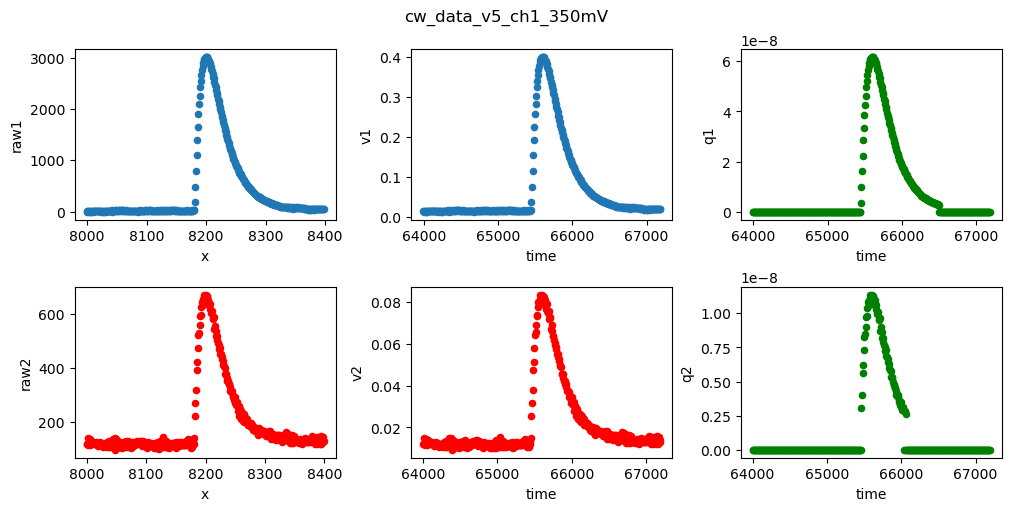

In [36]:
c = UserSettings()
c.update()
events = loop_events(c, 1)

In [32]:
events

Empty DataFrame
Columns: []
Index: []